## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = input_layer
            
        x = keras.layers.Dense(units=n_units, 
                               activation="relu", 
                               name="hidden_layer"+str(i+1))(x)
        x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)

In [13]:
# 繪製結果
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def plotResults(results):
    plt.figure(figsize=(8, 8))
    for i, cond in enumerate(results):
        plt.plot(range(len(results[cond]['train_loss'])), results[cond]['train_loss'], label=cond + '-train')
        plt.plot(range(len(results[cond]['valid_loss'])), results[cond]['valid_loss'], label=cond + '-valid')
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    plt.figure(figsize=(8, 8))
    for i, cond in enumerate(results):
        plt.plot(range(len(results[cond]['train_acc'])), results[cond]['train_acc'], label=cond + '-train')
        plt.plot(range(len(results[cond]['valid_acc'])), results[cond]['valid_acc'], label=cond + '-valid')
    plt.legend()
    plt.title("Accuracy")
    plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

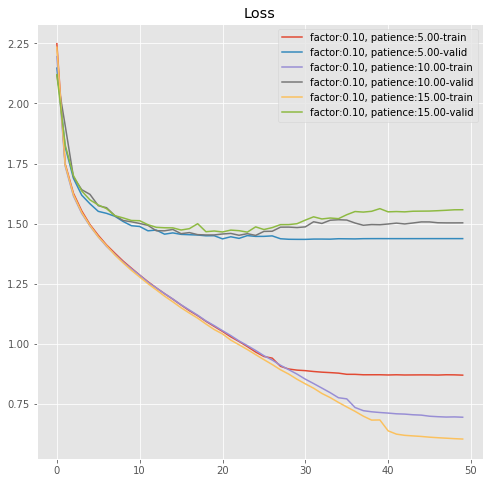

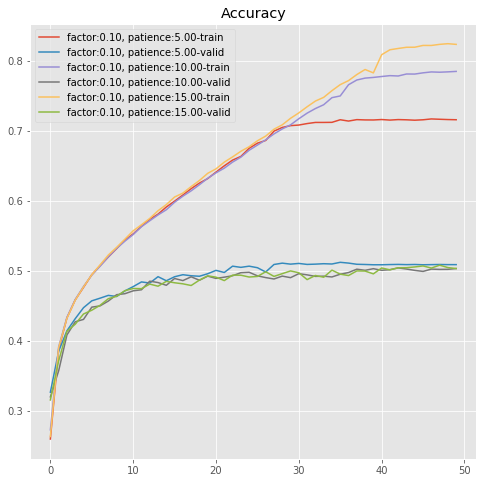

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

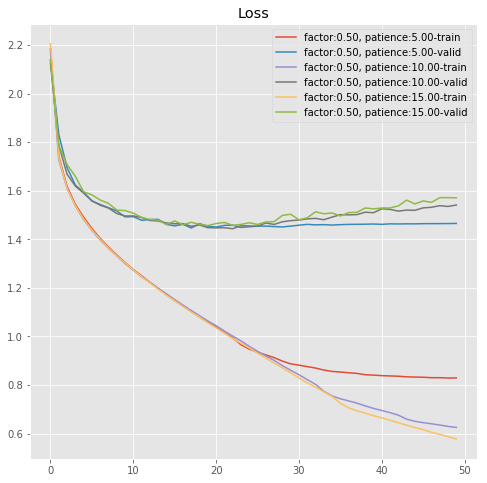

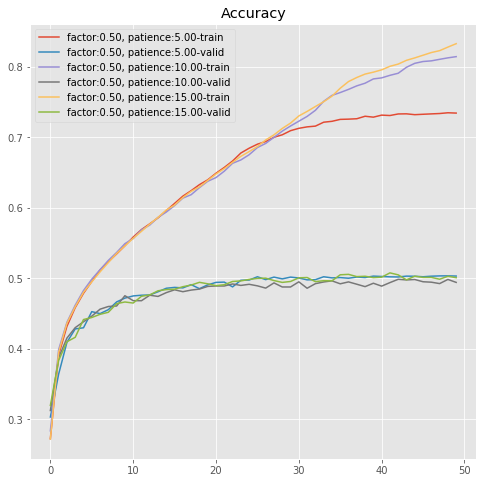

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

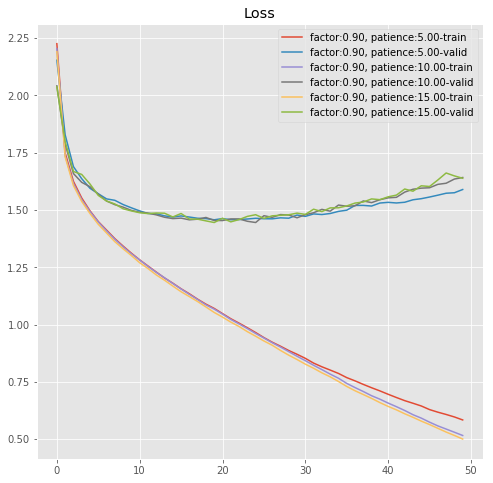

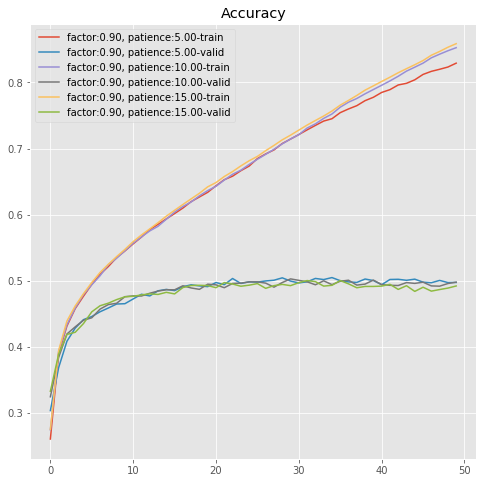

In [14]:
factor_list = [0.1, 0.5, 0.9]
patience_list = [5, 10, 15]

for factor in factor_list:
    results = {}
    show_summary = True
    
    for patience in patience_list:
        keras.backend.clear_session()
        model = build_mlp(input_shape=x_train.shape[1:])
        
        if show_summary == True:
            model.summary()
        show_summary = False
        
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        
        reduce_lr = ReduceLROnPlateau(factor=factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=patience, 
                              verbose=1)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True,
                  verbose=False,
                  callbacks=[reduce_lr]
                 )

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
        
        exp_var_name = 'factor:%.2f, patience:%.2f' %(factor, patience)
        results[exp_var_name] = {'train_loss': train_loss,
                                 'valid_loss': valid_loss,
                                 'train_acc': train_acc,
                                 'valid_acc': valid_acc
                                }
    plotResults(results)
    

# Conclusion 1
* 從上面的測試可以發現兩件事情：
* 1. factor 的數值不宜太小，避免調整 learning rate 的時候讓他變得過小，導致學習的步伐變慢。
* 2. patience 數值要搭配 factor 進行測試，避免在預定的訓練次數中，learning rate 還沒調整到適當的數值就結束訓練。

* 綜合上面的結論，這次測試得到的 factor 與 patience 最佳數值分別為 0.9 與 15。
* 第二個測試將會以這個為基準，進行討論使用不同 optimizer 的影響。

factor:0.90, patience:15.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)        

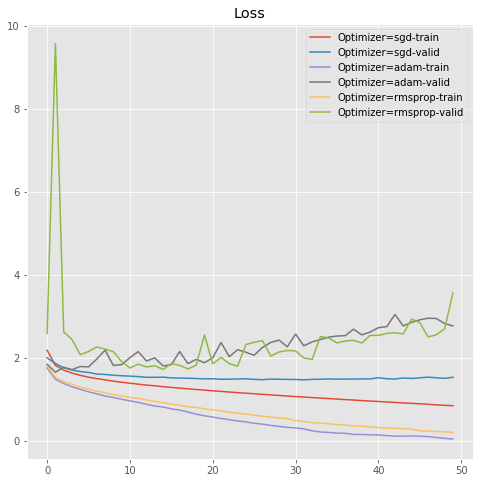

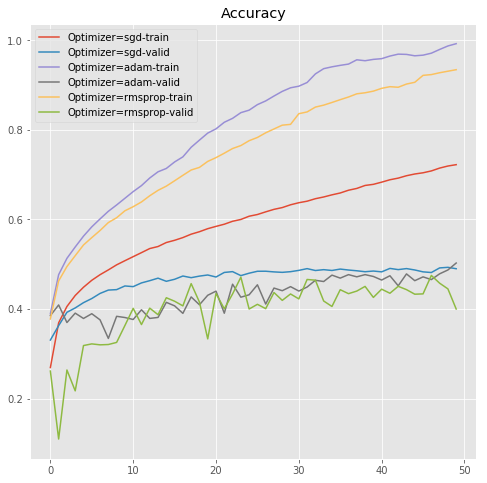

In [16]:
optimizer_list = ['sgd', 'adam', 'rmsprop']

factor = 0.9
patience = 15

reduce_lr = ReduceLROnPlateau(factor=factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=patience, 
                              verbose=1)

print('factor:%.2f, patience:%.2f' %(factor, patience))

results = {}
show_summary = True

for optimizer in optimizer_list:
    keras.backend.clear_session()
    model = build_mlp(input_shape=x_train.shape[1:])
    
    if show_summary == True:
        model.summary()
    show_summary = False
    
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              verbose=False,
              callbacks=[reduce_lr]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
        
    exp_var_name = 'Optimizer=' + optimizer
    results[exp_var_name] = {'train_loss': train_loss,
                             'valid_loss': valid_loss,
                             'train_acc': train_acc,
                             'valid_acc': valid_acc
                            }
    
plotResults(results)
    

# Conclusion 2
* 在測試 SGD, Adam, 與 RMSprop 三個不同的 optimizer 後發現，
* 雖然使用 Adam 在 train 上有最佳的表現，但是驗證的 valid 精準度反而是 SGD 表現比較好。

* 從結果可以反應出使用這三種 optimizer 的特性：
* 因為 SGD 主要是靠 gradient 進行收斂，而其他兩個還加有其他因素影響，
* 因此若 learning rate 可以調整到最佳值，使用 SGD 得到的效果會比其他的好。